<a href="https://colab.research.google.com/github/Woody-Wan/CS-542/blob/main/task2_template_InceptionResNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [ ]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

#### Load Image Data

In [ ]:
DATA_LIST = os.listdir('D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all')
DATASET_PATH  = 'D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all/train'
TEST_DIR =  'D:/Workspace/CS542/Class Challenge/Covid_Data_GradientCrescent/all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 24  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 150
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [ ]:
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(input_shape = (224, 224, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation = None)
InceptionResNetV2.trainable = False
flatten_1 = tf.keras.layers.Flatten()
dense_feature_1 = tf.keras.layers.Dense(256, kernel_regularizer='l2')
dense_feature_2 = tf.keras.layers.Dense(128, kernel_regularizer='l2')
Dropout = tf.keras.layers.Dropout(0.5)
dense_1 = tf.keras.layers.Dense(4)


model = tf.keras.Sequential([
  InceptionResNetV2,
  flatten_1,
  dense_feature_1,
  Dropout,
  dense_feature_2,
  Dropout,
  dense_1,
])

model_lowest_loss = model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense (Dense)               (None, 256)               9830656   
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                        

#### [5 points] Train Model

In [ ]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="Task2_best_weight_InceptionResNetV2_l0.001",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

#raise NotImplementedError("Use the model.fit function to train your network")
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits = True),optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE), metrics = ['accuracy'])
history = model.fit(train_batches, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,validation_data = valid_batches,steps_per_epoch = STEP_SIZE_TRAIN,validation_steps = STEP_SIZE_VALID, callbacks=[model_checkpoint_callback,reduce_lr])

9
3


C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\keras_preprocessing\image\image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/150
9/9 [==============================] - 115s 7s/step - loss: 54.7431 - accuracy: 0.3241 - val_loss: 39.4708 - val_accuracy: 0.3125 - lr: 5.0000e-04
Epoch 2/150
9/9 [==============================] - 42s 5s/step - loss: 53.5017 - accuracy: 0.3796 - val_loss: 25.5833 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 3/150
9/9 [==============================] - 35s 4s/step - loss: 48.2682 - accuracy: 0.3889 - val_loss: 31.8564 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 4/150
9/9 [==============================] - 37s 4s/step - loss: 40.9198 - accuracy: 0.4861 - val_loss: 34.8916 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/150
9/9 [==============================] - 41s 5s/step - loss: 33.6767 - accuracy: 0.5185 - val_loss: 23.4625 - val_accuracy: 0.5417 - lr: 5.0000e-04
Epoch 6/150
9/9 [==============================] - 39s 4s/step - loss: 34.8825 - accuracy: 0.5787 - val_loss: 18.3399 - val_accuracy: 0.6458 - lr: 5.0000e-04
Epoch 7/150
9/9 [==============================] - 

9/9 [==============================] - 21s 2s/step - loss: 23.6092 - accuracy: 0.6991 - val_loss: 21.6025 - val_accuracy: 0.6042 - lr: 5.0000e-04
Epoch 53/150
9/9 [==============================] - 21s 2s/step - loss: 28.9618 - accuracy: 0.6667 - val_loss: 22.0914 - val_accuracy: 0.6458 - lr: 5.0000e-04
Epoch 54/150
9/9 [==============================] - 20s 2s/step - loss: 24.4420 - accuracy: 0.6806 - val_loss: 19.3937 - val_accuracy: 0.6458 - lr: 5.0000e-04
Epoch 55/150
9/9 [==============================] - 21s 2s/step - loss: 25.0307 - accuracy: 0.6713 - val_loss: 17.9280 - val_accuracy: 0.6667 - lr: 5.0000e-04
Epoch 56/150
9/9 [==============================] - 21s 2s/step - loss: 23.9721 - accuracy: 0.6944 - val_loss: 18.2129 - val_accuracy: 0.6250 - lr: 5.0000e-04
Epoch 57/150
9/9 [==============================] - 20s 2s/step - loss: 24.5403 - accuracy: 0.7083 - val_loss: 17.7711 - val_accuracy: 0.6875 - lr: 5.0000e-04
Epoch 58/150
9/9 [==============================] - 22s 2s/

9/9 [==============================] - 21s 2s/step - loss: 18.8817 - accuracy: 0.7176 - val_loss: 20.2232 - val_accuracy: 0.6250 - lr: 5.0000e-04
Epoch 104/150
9/9 [==============================] - 22s 2s/step - loss: 20.5135 - accuracy: 0.7130 - val_loss: 15.5414 - val_accuracy: 0.6667 - lr: 5.0000e-04
Epoch 105/150
9/9 [==============================] - 22s 2s/step - loss: 18.6826 - accuracy: 0.6759 - val_loss: 18.7283 - val_accuracy: 0.7083 - lr: 5.0000e-04
Epoch 106/150
9/9 [==============================] - 21s 2s/step - loss: 20.2042 - accuracy: 0.7083 - val_loss: 17.8204 - val_accuracy: 0.6458 - lr: 5.0000e-04
Epoch 107/150
9/9 [==============================] - 22s 2s/step - loss: 19.0237 - accuracy: 0.6759 - val_loss: 16.5383 - val_accuracy: 0.7292 - lr: 5.0000e-04
Epoch 108/150
9/9 [==============================] - 25s 3s/step - loss: 19.1563 - accuracy: 0.7500 - val_loss: 12.5455 - val_accuracy: 0.7500 - lr: 5.0000e-04
Epoch 109/150
9/9 [==============================] - 2

#### [5 points] Plot Accuracy and Loss During Training

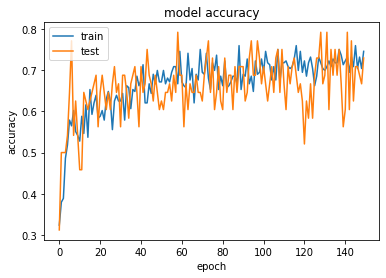

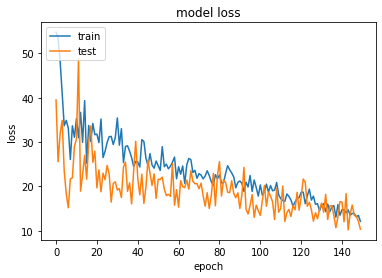

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Testing Model

In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36


C:\Users\woody\AppData\Local\Temp\ipykernel_8420\463003407.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),


36/36 [==============================] - 6s 170ms/step - loss: 12.4365 - accuracy: 0.7500
Test loss: 12.436456680297852
Test accuracy: 0.75


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


C:\Users\woody\AppData\Local\Temp\ipykernel_8420\429691970.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = intermediate_layer_model.predict_generator(tsne_eval_generator)
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\woody\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


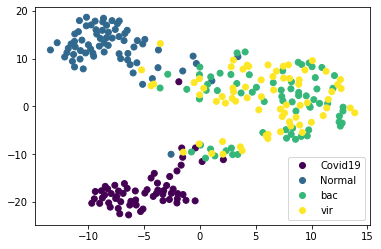

In [ ]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer('dense_2').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

tsne_eval_generator.reset()
pred = intermediate_layer_model.predict_generator(tsne_eval_generator)

tsne = TSNE(n_components=2,method='exact')
'''

    * use the generator to get images, pass them to interemediate_layer_model 
    * collect the output features into an array 
    * feed that array into fit_transform 

'''
        


#X_2d = tsne.fit_transform(pred)
tsne_result = tsne.fit_transform(pred)
scatter = plt.scatter(tsne_result[:,0], tsne_result[:,1], c=tsne_eval_generator.labels)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, ["Covid19","Normal","bac","vir"])




<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->